In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.applications import EfficientNetB1,EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

In [9]:
model=load_model('rectangle_crop.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 100, 160, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 100, 160, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 101, 161, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [2]:
test_path = r'roi_test'
labels=os.listdir(test_path)
labels

['Grade1', 'Grade2', 'Grade3', 'Normal']

In [6]:
X_test= []
y_test = []
for i in labels:
    folderPath = os.path.join(test_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        X_test.append(img)
        y_test.append(i)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(y_test.shape)
print(X_test.shape)

(320,)
(320, 100, 160, 3)


In [12]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
print(len(y_test_new))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)
print(y_test.shape)

320
(320, 4)


In [24]:
loss,accuracy=model.evaluate(X_test,y_test)

10/10 [==============================] - 29s 746ms/step - loss: 0.1982 - accuracy: 0.9531


In [8]:
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0

In [9]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print(kappa)

0.9375


In [10]:
from sklearn.metrics import precision_score,classification_report
target_names = labels
classification_report(y_test, y_pred,target_names=target_names,output_dict=True)

{'Grade1': {'precision': 0.9875,
  'recall': 0.9875,
  'f1-score': 0.9875,
  'support': 80},
 'Grade2': {'precision': 0.925,
  'recall': 0.925,
  'f1-score': 0.925,
  'support': 80},
 'Grade3': {'precision': 0.9605263157894737,
  'recall': 0.9125,
  'f1-score': 0.935897435897436,
  'support': 80},
 'Normal': {'precision': 0.9404761904761905,
  'recall': 0.9875,
  'f1-score': 0.9634146341463415,
  'support': 80},
 'micro avg': {'precision': 0.953125,
  'recall': 0.953125,
  'f1-score': 0.953125,
  'support': 320},
 'macro avg': {'precision': 0.9533756265664162,
  'recall': 0.953125,
  'f1-score': 0.9529530175109444,
  'support': 320},
 'weighted avg': {'precision': 0.953375626566416,
  'recall': 0.953125,
  'f1-score': 0.9529530175109443,
  'support': 320},
 'samples avg': {'precision': 0.953125,
  'recall': 0.953125,
  'f1-score': 0.953125,
  'support': 320}}

In [16]:
from sklearn.metrics import hamming_loss
ham_distance = hamming_loss(y_test,y_pred)
print(ham_distance)

0.0234375


In [17]:
from sklearn.metrics import jaccard_score
jaccard_score = jaccard_score(y_test,y_pred,average='macro')
print(jaccard_score)

0.9111758988123544


In [18]:
X_test= []
y_test = []
for i in labels:
    folderPath = os.path.join(test_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        X_test.append(img)
        y_test.append(i)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(y_test.shape)
print(X_test.shape)

(320,)
(320, 100, 160, 3)


In [19]:
from sklearn.metrics import hinge_loss
y_pred = model.predict(X_test)
hinge = hinge_loss(y_test,y_pred)
print(hinge)

0.11278874


In [20]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
print(len(y_test_new))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)
print(y_test.shape)

320
(320, 4)


In [25]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='ROI Image Confusion Matrix',
                          cmap=plt.cm.Greens, 
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4),dpi=300)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [26]:
def plot_confuse(model, x_val, y_val):
    predictions = model.predict(x_val, batch_size=16)
    predictions=np.argmax(predictions,axis=1)
    truelabel = y_val.argmax(axis=-1)
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    print(conf_mat)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=False, target_names=labels, title='ROI Image Confusion Matrix')

[[79  0  0  1]
 [ 1 74  3  2]
 [ 0  5 73  2]
 [ 0  1  0 79]]


<Figure size 432x288 with 0 Axes>

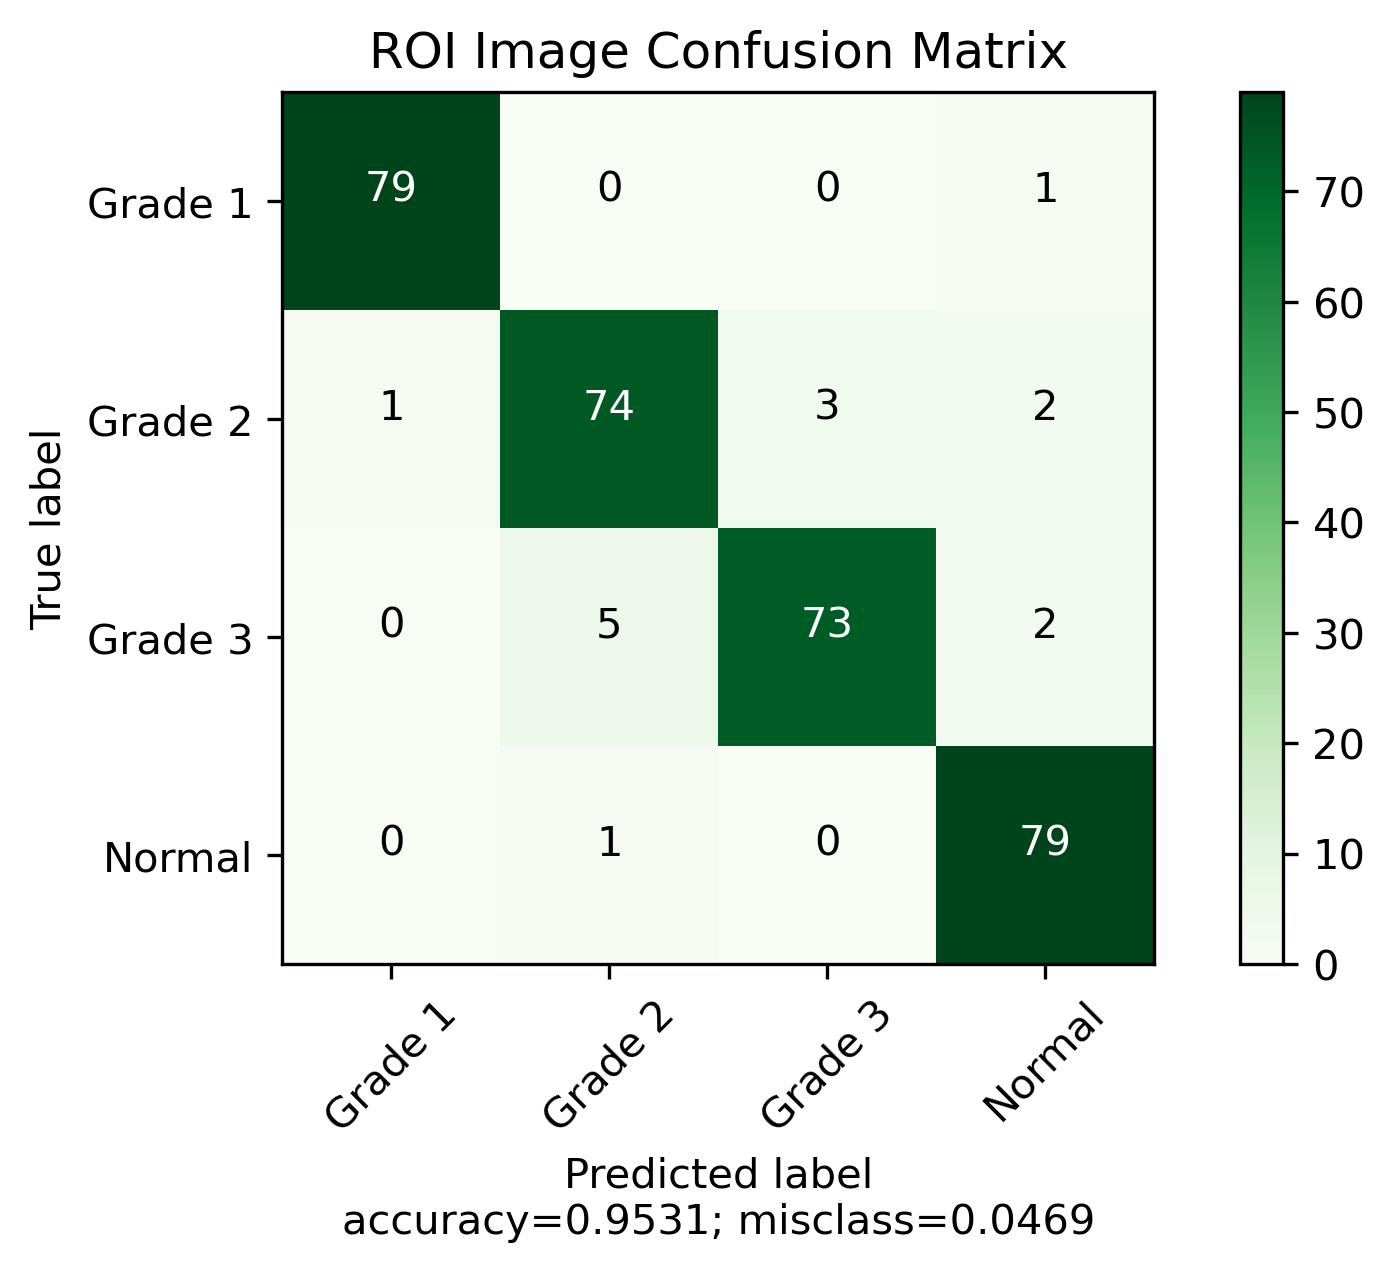

In [27]:
labels = ['Grade 1','Grade 2','Grade 3','Normal']
plot_confuse(model, X_test, y_test)